# Testing NASH on the CIFAR10 dataset

The Neural Architecture Search by Hill Climbing algorithm is tested on CIFAR-10.

The algorithme is described in: [*Thomas Elsken, Jan-Hendrik Metzen, Frank Hutter, **Simple And Efficient rchitecture Search for Convolutional Neural Networks**, arXiV:1711.04528*](https://arxiv.org/abs/1711.04528).

The **nni.networkmorphism_tuner** library from the Microsoft NNI package is used to represent a neural network as a graph and apply function-preserving morphisms.

In [1]:
# prerequisites
import torch
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt
import numpy as np
import time
from torchviz import make_dot
import os

from scipy import ndimage

# Custom modules
from datasets import train_test_split
from augmentations import Cutout
from nash import HillClimbingTuner
import training

In [2]:
# Dataset properties
INPUT_SIZE = 32
INPUT_CHN = 3
N_CLASS = 10

# Training parameters
BATCH_SIZE = 128
LEARNING_RATE = 2e-4
N_EPOCH_TRAIN = 10
L2_LAMBDA = 5e-4

# Search parameters
MODEL_PATH = "test_cifar_nash_final-regL2"
MAX_GEN = 8
N_MORPH = 4
GEN_SIZE = 8


## Datasets
The train dataset is split into a subset used to train candidate models and a cross-validation subset. The train subset is augmented with Cutout

In [3]:
kwargs={"root":'./cifar_data/', "download":False}
train_full = CIFAR10(train=True, **kwargs)
test_set = CIFAR10(train=False, transform=transforms.ToTensor(), **kwargs)

In [4]:
train_set, crossval_set = train_test_split(
    train_full,
    train_transform=
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            Cutout(
                default_color = [0.4914, 0.4822, 0.4465],
                patch_size=16,
                input_type="tensor",
                inplace=False
            )
        ]),
    test_transform=transforms.ToTensor(),
    ratio=0.8)

loader_args = {"batch_size": BATCH_SIZE, "pin_memory": True, "num_workers": 6}

train_loader = torch.utils.data.DataLoader(
    dataset=train_set, shuffle=True, **loader_args)
crossval_loader = torch.utils.data.DataLoader(
    dataset=crossval_set, shuffle=False, drop_last=False, **loader_args)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set, shuffle=False, drop_last=False, **loader_args)

full_train_loader = torch.utils.data.DataLoader(
    dataset=train_full, shuffle=False, drop_last=False, **loader_args)

## Set-up the tuner
The HillClimbingTuner is a subclass of **nni.networkmorphism_tuner.networkmorphism_tuner.NetworkMorphismTuner** with some methods overloaded so that is runs the NASH algorithm. The tuner object is in charge of providing the models to be trained, retreiving the results after trining and saving the trained models on disk with their parameters.

In [5]:
tuner = HillClimbingTuner(
    task = "cv",
    input_width = INPUT_SIZE,
    input_channel = INPUT_CHN,
    n_output_node = N_CLASS,
    optimize_mode = "minimize",
    path = MODEL_PATH,
    gen_size = GEN_SIZE)

## Training

In [6]:
model_nb = 0
gen_id = 0
n_iter = 0
timing = []
losses = []
accuracies = []
parameters = []
confusion_matrices = []

if os.path.isdir(tuner.path):
    filesToRemove = [os.path.join(tuner.path,f) for f in os.listdir(tuner.path)]
    
    if filesToRemove:
        answ = input("Directory %s exists, overwrite? (Y/n)"%tuner.path)
        while answ not in "Yn":
            answ = input("Directory %s exists, overwrite? (Y/n)"%tuner.path)
        if answ!="Y":
            raise RuntimeError("Directory exists!")

        for f in filesToRemove:
            os.remove(f)

In [7]:
t00 = time.time()
t0 = t00
while gen_id <= MAX_GEN:
    print("\n=========================")
    parameter_id = "gen%02d_model%d"%(gen_id,model_nb)
    print("Iteration %d - %s - %ds elapsed"%(n_iter,parameter_id, t0-t00))
    
    graph = tuner.generate_parameters(parameter_id)
    model = graph.produce_torch_model().cuda()
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)
    T = N_EPOCH_TRAIN * (2 if n_iter==0 else 1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T)
    
    try:
        training.train_net(model, train_loader, optimizer, n_epoch=T, verbose=1, lr_scheduler = scheduler)

        loss, accuracy, confusion = training.test_net(model, crossval_loader)
        loss_t, accuracy_t, confusion_t = training.test_net(model, test_loader)
    except KeyboardInterrupt:
        raise
    except: # got a bug once... throw the bad model and move on
        loss, loss_t = 9999., 9999.
        accuracy, accuracy_t = 0., 0.
        confusion = np.zeros((N_CLASS,N_CLASS),dtype=int)
        confusion_t = np.zeros((N_CLASS,N_CLASS),dtype=int)
        print("ERROR")
    model.cpu()
    model.set_weight_to_graph()
    tuner.receive_trial_result(parameter_id, loss, model)  
        
    parameters.append(parameter_id)
    print("Best model so far : %s (%d)"%(parameters[tuner.get_best_model_id()],tuner.get_best_model_id()))
        
    n_iter += 1
    if tuner.training_queue: 
        model_nb += 1
    else:
        gen_id += 1
        model_nb = 0
    
    t1=time.time()
    timing.append(t1-t0)
    t0=t1
    losses.append([loss,loss_t])
    accuracies.append([accuracy,accuracy_t])
    confusion_matrices.append([confusion, confusion_t])
    
tt = t1-t00
h = (tt)//3600
m = (tt - 3600*h)//60
s = (tt - 3600*h - 60*m)//1
print("******** DONE ********")
print("Full NAS search done in %dh %dm %ds seconds"%(h,m,s))

accuracies = np.array(accuracies)
losses = np.array(losses)
timing = np.array(timing)
cm = np.array(confusion_matrices)
arr_path = os.path.join(tuner.path, "metrics.npz")
np.savez(arr_path, timing=timing,
        losses=losses, accuracies=accuracies, confusion_matrices=cm)


Iteration 0 - gen00_model0 - 0s elapsed
Training done, 20 epochs in 115.9s, loss at last epoch: 1.0743
Well classified  6446 / 10000, (64.46% accuracy)
Average loss : 0.991343
Well classified  6465 / 10000, (64.65% accuracy)
Average loss : 0.984072
Best model so far : gen00_model0 (0)

Iteration 1 - gen01_model0 - 120s elapsed
Training done, 10 epochs in 56.3s, loss at last epoch: 0.9872
Well classified  6735 / 10000, (67.35% accuracy)
Average loss : 0.913315
Well classified  6802 / 10000, (68.02% accuracy)
Average loss : 0.905432
Best model so far : gen01_model0 (1)

Iteration 2 - gen01_model1 - 178s elapsed
Training done, 10 epochs in 81.8s, loss at last epoch: 0.9464
Well classified  6920 / 10000, (69.20% accuracy)
Average loss : 0.874526
Well classified  6951 / 10000, (69.51% accuracy)
Average loss : 0.867929
Best model so far : gen01_model1 (2)

Iteration 3 - gen01_model2 - 262s elapsed
Training done, 10 epochs in 113.1s, loss at last epoch: 0.9513
Well classified  6837 / 10000, 

Training done, 10 epochs in 517.1s, loss at last epoch: 0.2370
Well classified  8652 / 10000, (86.52% accuracy)
Average loss : 0.445406
Well classified  8645 / 10000, (86.45% accuracy)
Average loss : 0.459965
Best model so far : gen03_model1 (20)

Iteration 27 - gen03_model8 - 7960s elapsed
Training done, 10 epochs in 414.3s, loss at last epoch: 0.4177
Well classified  8083 / 10000, (80.83% accuracy)
Average loss : 0.603151
Well classified  8034 / 10000, (80.34% accuracy)
Average loss : 0.618445
Best model so far : gen03_model1 (20)

Iteration 28 - gen04_model0 - 8383s elapsed
Training done, 10 epochs in 583.0s, loss at last epoch: 0.1812
Well classified  8724 / 10000, (87.24% accuracy)
Average loss : 0.435891
Well classified  8723 / 10000, (87.23% accuracy)
Average loss : 0.434885
Best model so far : gen03_model1 (20)

Iteration 29 - gen04_model1 - 8983s elapsed
Training done, 10 epochs in 822.8s, loss at last epoch: 0.1795
Well classified  8764 / 10000, (87.64% accuracy)
Average loss

Training done, 10 epochs in 969.7s, loss at last epoch: 0.1565
Well classified  8955 / 10000, (89.55% accuracy)
Average loss : 0.325142
Well classified  8941 / 10000, (89.41% accuracy)
Average loss : 0.326788
Best model so far : gen06_model1 (47)

Iteration 54 - gen06_model8 - 28368s elapsed
Training done, 10 epochs in 885.3s, loss at last epoch: 0.1539
Well classified  8982 / 10000, (89.82% accuracy)
Average loss : 0.321468
Well classified  8947 / 10000, (89.47% accuracy)
Average loss : 0.326748
Best model so far : gen06_model8 (54)

Iteration 55 - gen07_model0 - 29272s elapsed
Training done, 10 epochs in 886.0s, loss at last epoch: 0.1256
Well classified  8999 / 10000, (89.99% accuracy)
Average loss : 0.335925
Well classified  8953 / 10000, (89.53% accuracy)
Average loss : 0.330549
Best model so far : gen06_model8 (54)

Iteration 56 - gen07_model1 - 30187s elapsed
Training done, 10 epochs in 1037.8s, loss at last epoch: 0.1314
Well classified  9006 / 10000, (90.06% accuracy)
Average 

## Display results
Now, display the training results, confusion matrix and final graph architecture. 

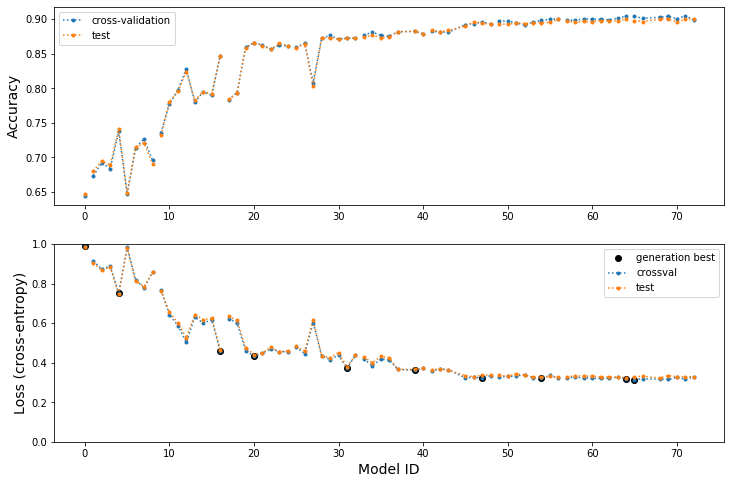

In [12]:
def insert_gap(vec, gen_size=GEN_SIZE):
    """
    Inser a nan in the vector between generations
    Remove bad values
    """
    n_models = vec.size
    model_id = np.arange(vec.size)
    gen = 1 + (model_id-1)//gen_size
    last_gen = gen[-1]

    ind = np.empty((n_models+last_gen,))
    ind[:] = np.nan
    val = np.empty((n_models+last_gen,))
    val[:] = np.nan

    ind[model_id+gen] = model_id
    val[model_id+gen] = vec
    
    valid  = np.logical_and(val!=9999, val!=0)
    ind = ind[valid]
    val = val[valid]
    
    return ind, val


def get_best_metric(vec, gen_size=GEN_SIZE):
    """Return id and metric of best model at each generation"""
    n_models = vec.size
    model_id = np.arange(vec.size)
    gen = 1 + (model_id-1)//gen_size
    n_gen = gen[-1]+1
    best_id, best_metric = np.zeros((n_gen)), np.zeros((n_gen))
    for ii in range(n_gen):
        imin = vec[gen == ii].argmin()
        shift = 0 if 0 == ii else 1+(ii-1)*gen_size
        best_id[ii] = imin+shift
        best_metric[ii] = vec[imin+shift]
    return best_id, best_metric


plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(*insert_gap(accuracies[:, 0]), ".:", label="cross-validation")
plt.plot(*insert_gap(accuracies[:, 1]), ".:",label="test")
plt.legend()
plt.ylabel("Accuracy", fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(*get_best_metric(losses[:, 0]), "ok", label="generation best")
plt.plot(*insert_gap(losses[:, 0]), ".:",label="crossval")
plt.plot(*insert_gap(losses[:, 1]), ".:",label="test")
plt.ylabel("Loss (cross-entropy)", fontsize=14)
plt.xlabel("Model ID", fontsize=14)
plt.ylim(0.,1.)
plt.legend();

In [9]:
best_id = tuner.get_best_model_id()
print("The confusion matrix for the best model is:")
print(np.array2string(cm[best_id,1]))

The confusion matrix for the best model is:
[[894   4  21   9   2   4   7   3  24  10]
 [  5 948   1   2   1   1   1   1  10  31]
 [ 31   1 878  22  18  23  17  12   3   2]
 [  5   3  19 791  22 111  24  15   4   3]
 [  9   1  26  32 904  16   7  19   0   3]
 [  2   1  27  84  16 818   5  25   0   0]
 [  3   1  17  40  17   8 937   0   2   1]
 [  4   0   5  11  19  15   0 923   2   1]
 [ 31   3   3   4   1   2   1   1 946  10]
 [ 16  38   3   5   0   2   1   1   9 939]]


parameters in best model: 11048470


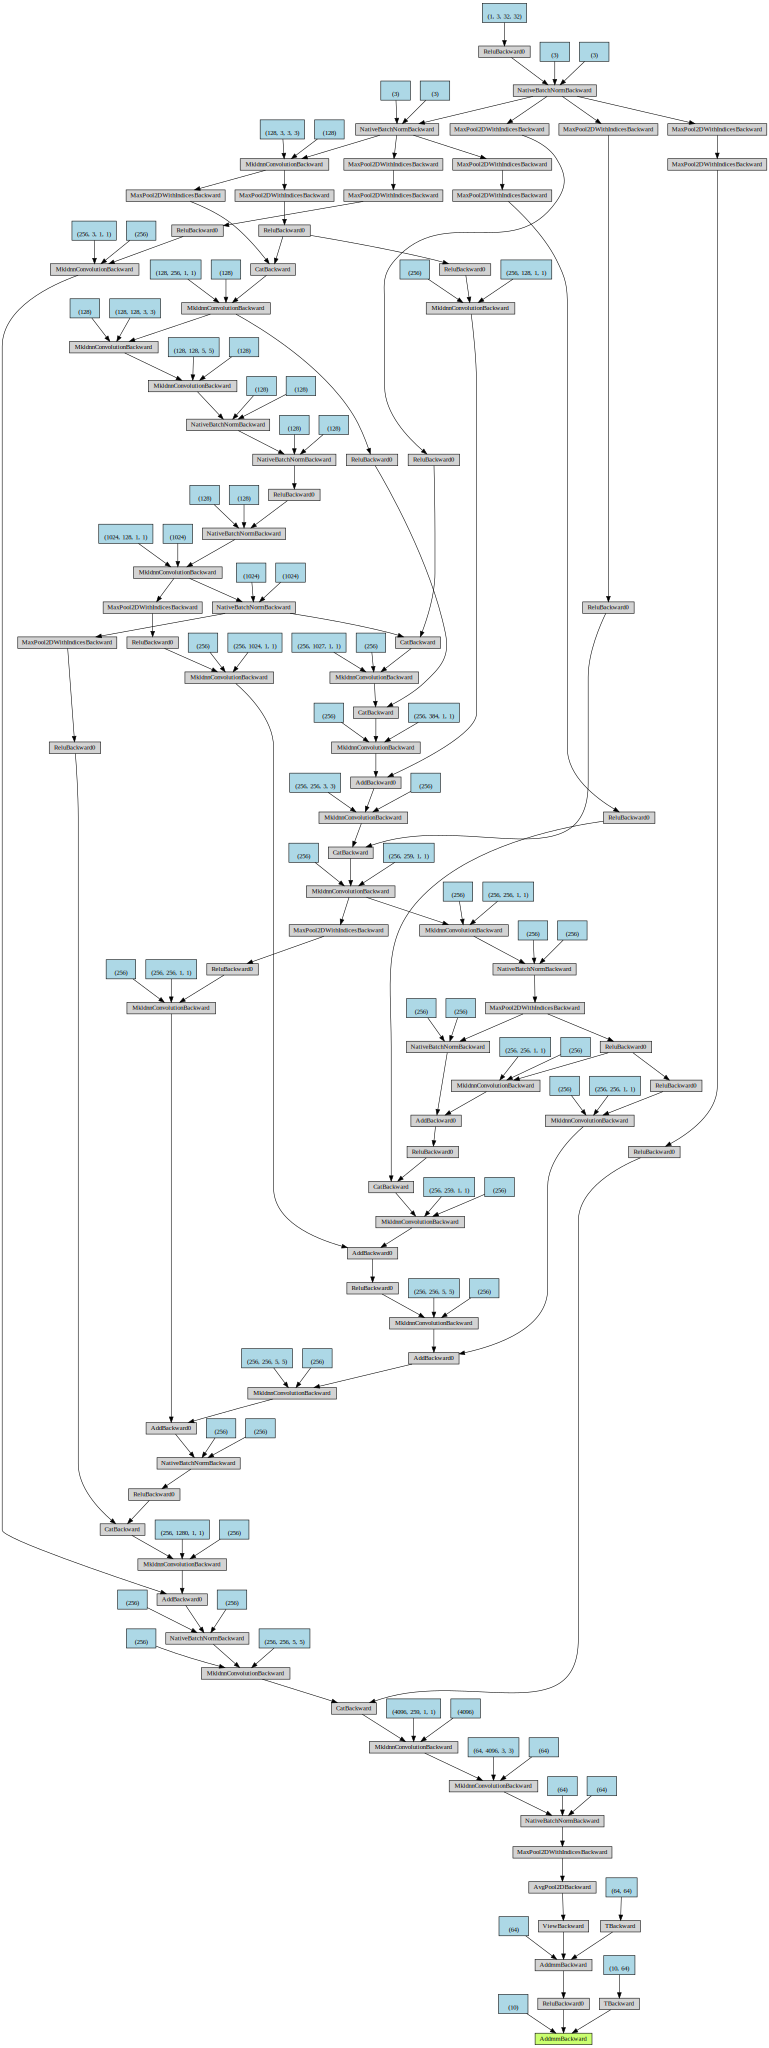

In [10]:
best_id = tuner.get_best_model_id()
best_graph = tuner.load_model_by_id(best_id, load_weights=True)
best_model = best_graph.produce_torch_model()
best_model.eval()

params = sum([p.numel() for p in best_model.parameters()])
print("parameters in best model:", params)

x,y = test_set[0]
x.unsqueeze_(0)
z = torch.zeros_like(x, requires_grad=True)

make_dot(best_model(z))

